# Topic modeling

Notebook created by [Gonzalo Córdova](https://github.com/gonzalo-cordova-pou) in May 2023. (Last update: May 2023)
For any doubts: gonzalo.cordova@estudiantat.upc.edu

This notebook is an approach to topic modeling. The aim is to find the topics of a set of screenshots. The text used is the output of the OCR of the screenshots.

## Table of contents

- [Load fastText](#Load-fasttext)
- [Topic definition](#Topic-definition)
- [Load and clean data](#Load-and-clean-data)
- [Topic modeling](#Topic-modeling)
- [Results](#Results)

In [1]:
import NLPutils as nlp
import pandas as pd
import numpy as np
from sklearn.metrics import top_k_accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gonzalo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gonzalo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Load fasttext

fastText is a library for efficient learning of word representations and sentence classification.

Find more information about fastText [here](https://fasttext.cc/docs/en/aligned-vectors.html).
The current version being used is `wiki.en.vec` from [here](https://fasttext.cc/docs/en/pretrained-vectors.html). Custom the directory in NLPutils.py.

We use our NLPutils module to load the fasttext model:

*Note: The following cell takes a while to run.*

In [2]:
model = nlp.load_model()

Lets see an example of the model embeddings with the word "physics":

In [3]:
model['physics'][:10]

array([-0.030296, -0.27108 ,  0.17324 ,  0.44757 , -0.017513,  0.065391,
       -0.042368, -0.43282 ,  0.18655 ,  0.2126  ], dtype=float32)

## Topic definition

Each topic is defined by a set of words that we will call "keywords". Each of those keywords will have an embedding representation. The topic embedding is the centroid of the embeddings of the keywords. The topic centroid will be used to find the most similar topics to a given text.

- We load the topic keywords embeddings,
- We calculate the topic centroids,

Let's see the names of the topics:

In [4]:
topic_keywords_embed = nlp.get_topic_keywords_embed(model)
topic_centroids = nlp.get_topic_centroids(topic_keywords_embed)
print(list(topic_centroids.keys()))

['ComputerScience', 'Chemistry', 'Physics', 'Math&Statistics', 'Pharma', 'Biology', 'Psychology', 'Business', 'Gender', 'Philosophy&Ethics', 'Politics&Society', 'Arts', 'Astronomy', 'Literature']


The following cell searchs for the top k nearest words to each topic centroid. This can be used to get a sort of explainability of the topics.

*Note: The following cell takes a while to run.*

In [5]:
# OPTIONAL - Get the 10 nearest words to each centroid
# centroid_near_words = get_k_nearest_words_from_cat(centroids, model, 10)
# centroid_near_words

## Load and clean data

Lets load the dataset containing the OCR output of the screenshots. We will filter the dataset to only keep the screenshots of the "focused" category.
Note that we drop the rows with empty text.

In [6]:
# Read data into papers
data = pd.read_csv('dataset.csv', sep=';')
data = data.dropna(subset=['text'])
data = data[data['class'] == 0] # Only "focused" class
data['course'] = data['image'].apply(lambda x: x.split('_')[1]) # Extract course from 'image' column
courses = set(data['course']) # Extract set of courses
data.head()

,class,text,image,course
0,0,Next? < Pre\ Here are slide . ES02 Session ¢ s...,focused_Algorithms_one_0.jpg,Algorithms
1,0,wax Next? < Prey Here are My ae) Ac Creativ ra...,focused_Algorithms_one_1.jpg,Algorithms
2,0,ee Next? < Prey an —. th Here are My ae) Ac ea...,focused_Algorithms_one_10.jpg,Algorithms
3,0,eK (h) P2* Pi2° ~yP: eps a Po (h) Graham’s Sca...,focused_Algorithms_one_100.jpg,Algorithms
4,0,ee Graham’s Scan: Start with bottom point Calc...,focused_Algorithms_one_101.jpg,Algorithms


Now we will map the `course` column to the `topic` column. This will be done using the `nlp.group_courses` function. This function takes a list of courses and returns the topic that best represents them according to a dictionary in the `NLPutils` module.

Let's see the distribution of the topics:

In [7]:
# Create a new column called 'topic' that has the value of the course group
data['topic'] = data['course'].apply(nlp.group_courses)
data = data.dropna(subset=['topic'])
data = data.dropna(subset=['text'])
if set(topic_centroids.keys()) != set(data['topic'].unique()):
    raise Exception('The topic centroids and the data topics are not the same')
# Print the number of courses per topic
data['topic'].value_counts()

topic
Politics&Society     1419
ComputerScience       866
Chemistry             809
Biology               694
Business              607
Math&Statistics       510
Philosophy&Ethics     482
Astronomy             269
Literature            265
Gender                191
Pharma                141
Arts                   93
Physics                79
Psychology             37
Name: count, dtype: int64

Now we generate an id for each topic:

In [8]:
# Set a topic index
data['topic_id'] = data['topic'].factorize()[0]
# Create a dict where key = topic and value = topic_id
topic_to_id = dict(data[['topic', 'topic_id']].drop_duplicates().sort_values('topic_id').values)
topic_to_id

{'ComputerScience': 0,
 'Arts': 1,
 'Astronomy': 2,
 'Biology': 3,
 'Business': 4,
 'Chemistry': 5,
 'Math&Statistics': 6,
 'Philosophy&Ethics': 7,
 'Gender': 8,
 'Physics': 9,
 'Politics&Society': 10,
 'Psychology': 11,
 'Literature': 12,
 'Pharma': 13}

We keep only the columns we need:

In [9]:
# Drop the columns that are not needed: 'class', 'image', 'course', 'topic'
data = data.drop(columns=['class', 'image', 'course', 'topic'])
data.head()

,text,topic_id
0,Next? < Pre\ Here are slide . ES02 Session ¢ s...,0
1,wax Next? < Prey Here are My ae) Ac Creativ ra...,0
2,ee Next? < Prey an —. th Here are My ae) Ac ea...,0
3,eK (h) P2* Pi2° ~yP: eps a Po (h) Graham’s Sca...,0
4,ee Graham’s Scan: Start with bottom point Calc...,0


We clean the text:

In [10]:
text = data.text
stop_words = nlp.get_stopwords()
data_words = nlp.remove_stopwords(list(nlp.sent_to_words([nlp.clean(doc) for doc in text])), stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gonzalo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Topic modeling

Inside the `NLPutils` module we have several functions to perform topic modeling:
- `nearest_cat` returns the nearest topic (and distance) to a given text.
- `nlp.sentence_nearest_cat` returns the nearest topic (and distance) to a given text (list of words).
- `sentence_cats_probs` returns the probability of each topic given a text (list of words).

In [11]:
nlp.nearest_cat(topic_centroids, 'physics', model)

('Physics', 3.3009569672380294)

In [12]:
nlp.sentence_nearest_cat(data_words[0], topic_centroids, model)

('ComputerScience', 1.7229635259456093)

In [13]:
nlp.sentence_cats_probs(data_words[0], topic_centroids, model, topic_to_id)

array([0.14751143, 0.11745357, 0.03821216, 0.04903981, 0.09101458,
       0.04480395, 0.08543381, 0.04318532, 0.0351992 , 0.07638834,
       0.10013186, 0.07482327, 0.06863468, 0.02816802])

## Results

Let's run the `sentence_cats_probs` function on the dataset:

In [14]:
preds = []
for i in range(len(data_words)):
    preds.append(nlp.sentence_cats_probs(data_words[i], topic_centroids, model, topic_to_id))
data["preds"] = preds

Now we can use the top-k accuracy metric to evaluate the results:

*For more information about this metric, check [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.top_k_accuracy_score.html#:~:text=Top%2Dk%20Accuracy%20classification%20score,(ranked%20by%20predicted%20scores).) link.*

In [15]:
y_true = np.array(data.topic_id.to_list())
y_score = np.array(data.preds.to_list())
accs = []
ks = []
for i in range(1+len(topic_centroids.keys())):
    accs.append(top_k_accuracy_score(y_true, y_score, k=i))
    ks.append(i)

c:\Users\Gonzalo\anaconda3\envs\MLADHD_env\lib\site-packages\sklearn\metrics\_ranking.py:1802: UndefinedMetricWarning: 'k' (14) greater than or equal to 'n_classes' (14) will result in a perfect score and is therefore meaningless.
  warnings.warn(


We plot the results for each k from 1 to number of topics:

In [42]:
# random guess (0, 1/len(topic_centroids.keys()), 2/len(topic_centroids.keys()), ...)
random_guess = [i/len(topic_centroids.keys()) for i in range(len(topic_centroids.keys())+1)]

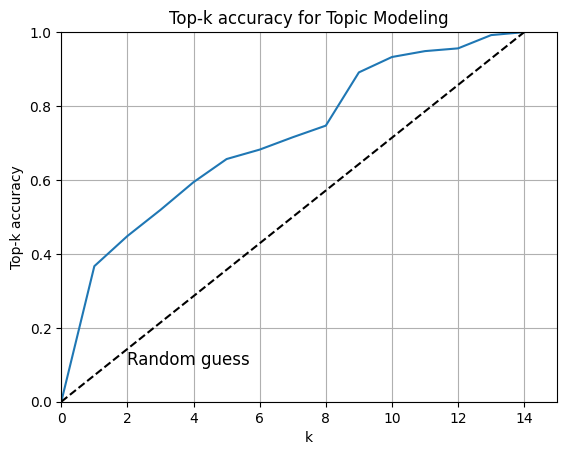

In [43]:
# plot the top k accuracy scores
import matplotlib.pyplot as plt
plt.plot(ks, accs)
plt.plot([i for i in range(len(topic_centroids.keys())+1)], random_guess, linestyle='--', color='black')
# add label to the line
plt.text(2, 0.1, 'Random guess', fontsize=12)
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 15)
plt.title('Top-k accuracy for Topic Modeling')
plt.xlabel('k')
plt.ylabel('Top-k accuracy')
plt.show()

In [44]:
accs

[0.0,
 0.36675951717734445,
 0.44831321572268645,
 0.5190343546889508,
 0.5940885174868462,
 0.6566078613432373,
 0.6821417517796348,
 0.715567935623646,
 0.7469823584029712,
 0.8910554008047045,
 0.9326833797585887,
 0.9486227174249459,
 0.9560507582791705,
 0.9919529557412565,
 1.0]